In [57]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [58]:
def f (x):
  return 3*x**2-4*x+5

In [59]:
f(3)

20

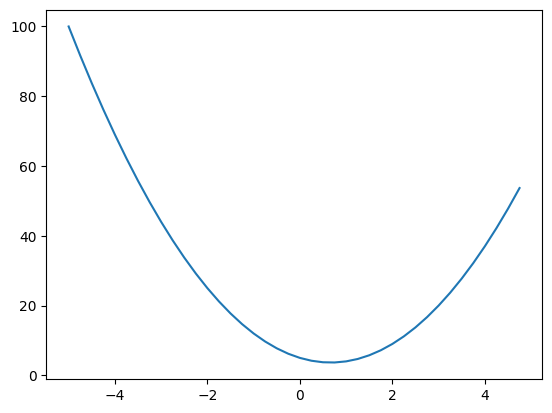

In [60]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [61]:
h = 0.0001
x = 1
print(f(x))
print(f(x+h))
(f(x+h)-f(x))/h

4
4.00020003


2.0003000000023974

In [62]:
a = 2.0
b = -3.0
c = 10.0
d = a*b+c
print(d)

4.0


In [63]:
h = 0.001
# inputs
a = 2.0
b = -3.0
c = 10.0
d1 = a*b+c
a+=h
d2 = a*b+c
print((d2-d1)/h)

-3.0000000000001137


In [64]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [65]:
a = Value(2.0)
b = Value(3.0)
a-b

Value(data=-1.0)

In [66]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L


Value(data=-8.0)

In [67]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [68]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

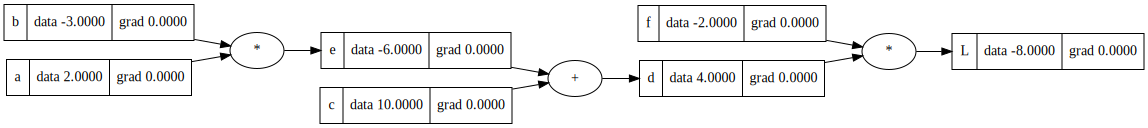

In [69]:
draw_dot(L)

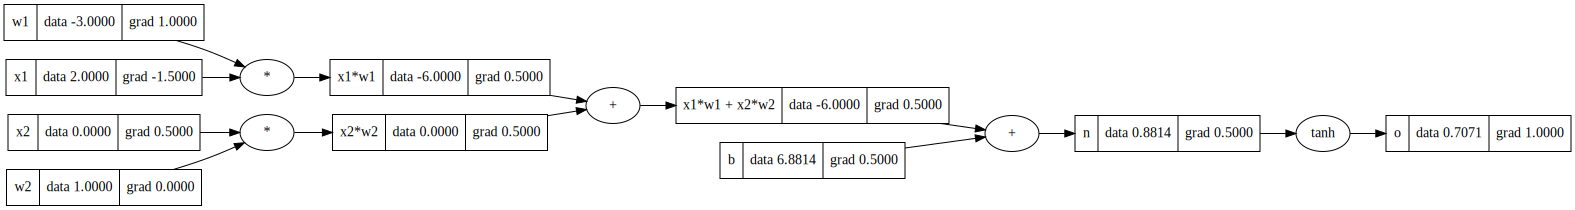

In [70]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

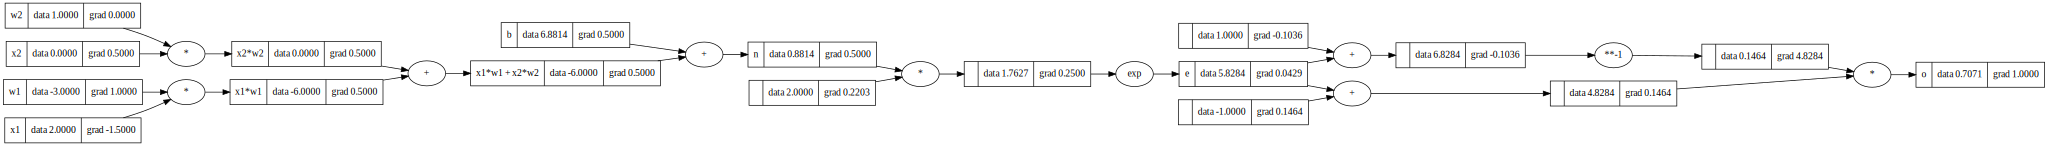

In [71]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
e.label = 'e'
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

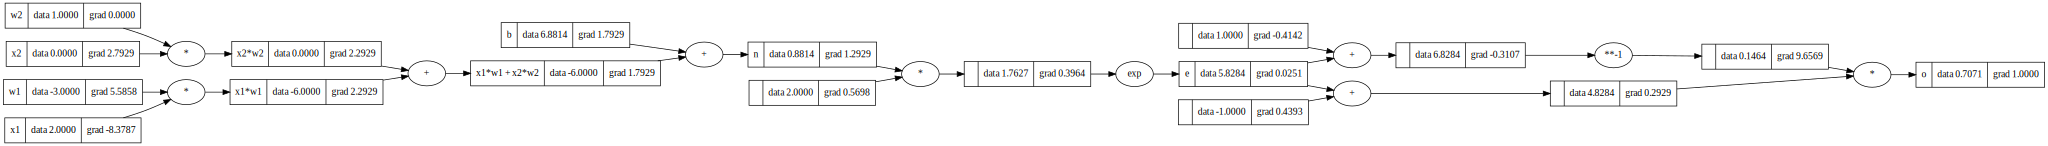

In [72]:
o.backward()
draw_dot(o)

In [73]:
L.grad = 1.0

In [74]:
d.grad = -2.0
f.grad = 1.0


In [75]:
# this is intersting L = d*f L = (e+c)*f so dL/de = f
# dL/de = dL/dd * dd/de and dd/de = 1 dL/dd *dd/dc
e.grad = -2.0
c.grad = -2.0
a.grad = e.grad *b.data
b.grad = e.grad *a.data

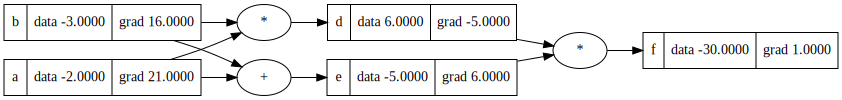

In [76]:
a = Value(-2.0,label = 'a')
b = Value(-3.0,label = 'b')
d = a*b ; d.label = 'd'
e = a+b; e.label = 'e'
f = d*e ; f.label = 'f'

f.backward()
draw_dot(f)

### Usinf pytorch to verify our solution

In [77]:
import torch

In [78]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad= True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad= True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad= True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad= True
b  = torch.Tensor([6.88137]).double();b.requires_grad = True

n = w1*x1 + w2*x2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('x1', x1.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())


0.7071050214706146
---
x2 0.5000024886110417
x1 -1.500007465833125
w1 1.0000049772220834
w2 0.0


In [79]:
import numpy as np
import random

In [82]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    n = len(x)
    act = 0
    for i in range(n):
      act = act+self.w[i]*x[i]
    act+=self.b
    out = act.tanh()
    return out


    # act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    # out = act.tanh()
    # return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]

In [85]:
neuron = Neuron(3)
print(neuron.w)
print(neuron.b)
x = [1,2,3]
sum = 0
for i in range(3):
  sum = sum+neuron.w[i]*x[i]
output =(sum+neuron.b).tanh()
print(output)
print()
neuron([1,2,3])


[Value(data=0.14514513417978292), Value(data=0.8983485782621214), Value(data=0.8904500683043861)]
Value(data=0.5615059961225628)
Value(data=0.9999359778739292)



Value(data=0.9999359778739292)

In [112]:
l1 = Layer(3,4)
l1([1.0,2.0,3.0])
n1 = l1.neurons[0]
print(n1.w)
print(n1.b)
print(n1([1.0,2.0,3.0]))
o1 = l1([1.0,2.0,3.0])[0]

[Value(data=-0.8889987687248839), Value(data=-0.01681223978479185), Value(data=0.7823582996646374)]
Value(data=-0.19095592859009125)
Value(data=0.8435903131893142)


In [113]:
o1.backward()

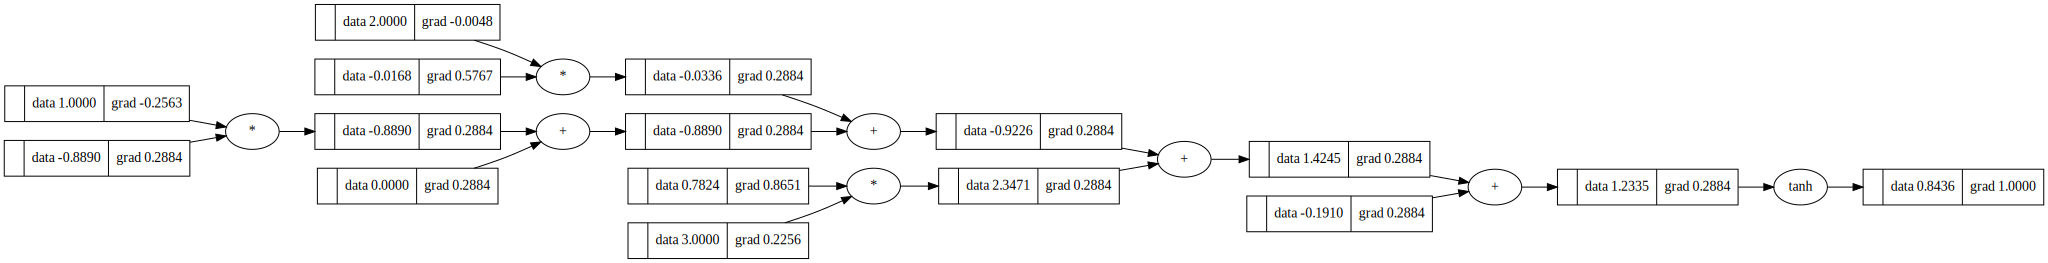

In [114]:
draw_dot(o1)

In [115]:
x = [2.0,3.0,-1.0]
nn = MLP(3,[4,4,1])
nn(x)

Value(data=0.3211103057045284)

In [117]:
nn(x).backward()

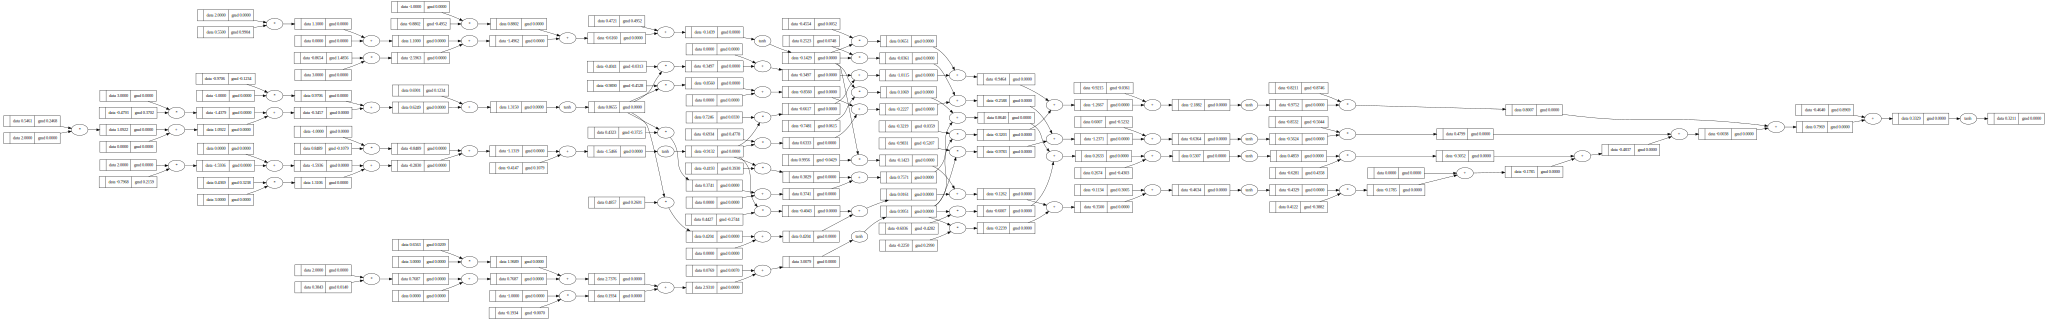

In [118]:
draw_dot(nn(x))

In [200]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [201]:
neural_network = MLP(3,[4,4,1])


In [202]:
y_pred = [neural_network(input) for input in xs]
print(y_pred)

[Value(data=-0.9073969535636922), Value(data=-0.9535774464192311), Value(data=-0.8765449447183232), Value(data=-0.9087433435687408)]


In [210]:
# forward pass
loss = 0
for i in range (len(y_pred)):
  loss = loss +(y_pred[i]-ys[i])**2
print(loss)

Value(data=4.129052126592772)


In [217]:
x = neural_network.parameters()[0]
print(x.data)

-0.18895087169139146


In [239]:
for i in neural_network.parameters():
  i.grad = 0.0

In [240]:
loss.backward()

In [241]:
for x in neural_network.parameters():
  x.data += -0.05*x.grad

In [242]:
loss = 0
y_pred = [neural_network(input) for input in xs]
for i in range (len(y_pred)):
  loss = loss +(y_pred[i]-ys[i])**2
print(loss)

Value(data=0.3925165783010214)


In [243]:
print(y_pred)

[Value(data=0.5680551953441323), Value(data=-0.9346228228273367), Value(data=-0.6309456107753186), Value(data=0.744138813942487)]


In [246]:
for k in range(20):
  loss = 0
  y_pred = [neural_network(input) for input in xs]
  for i in range (len(y_pred)):
    loss = loss +(y_pred[i]-ys[i])**2
  for p in neural_network.parameters():
    p.grad = 0.0
  loss.backward()
  for p in neural_network.parameters():
    p.data += -0.05*p.grad
  print(k,loss.data,"values",y_pred)

0 0.023864557186425432 values [Value(data=0.9042313453280754), Value(data=-0.9691201884583144), Value(data=-0.9037319603072139), Value(data=0.9331283038826349)]
1 0.02281350840039094 values [Value(data=0.9064570198791643), Value(data=-0.9695670929608486), Value(data=-0.905908245635472), Value(data=0.9345492612703602)]
2 0.021852170602808654 values [Value(data=0.9085367479185399), Value(data=-0.9699905243958761), Value(data=-0.9079406286199445), Value(data=0.9358817682981942)]
3 0.02096946248779962 values [Value(data=0.9104858170981336), Value(data=-0.9703926256381957), Value(data=-0.9098443892167504), Value(data=0.9371347252061203)]
4 0.020156061144513765 values [Value(data=0.9123173639890166), Value(data=-0.9707752652609306), Value(data=-0.9116326245251978), Value(data=0.9383158179286981)]
5 0.019404066013970486 values [Value(data=0.9140427478992196), Value(data=-0.9711400820336341), Value(data=-0.9133166341235547), Value(data=0.9394317241407821)]
6 0.01870673714148335 values [Value(d

In [247]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
neural_network = MLP(3,[4,4,1])


In [253]:
k_values = []
loss_values = []

In [254]:
for k in range(20):
  loss = 0
  y_pred = [neural_network(input) for input in xs]
  for i in range (len(y_pred)):
    loss = loss +(y_pred[i]-ys[i])**2
  for p in neural_network.parameters():
    p.grad = 0.0
  loss.backward()
  for p in neural_network.parameters():
    p.data += -0.05*p.grad

  #print(k,loss.data,"values",y_pred)
  k_values.append(k)
  loss_values.append(loss.data)

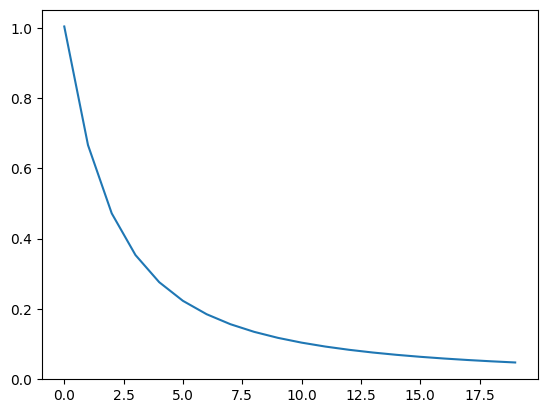

In [255]:
plt.plot(k_values,loss_values)